## From [gc-fit/simulation.ipynb](https://github.com/matsengrp/gc-fit/blob/main/simulation.ipynb)

In [124]:
import jax.numpy as np
from jax import random
from jax.scipy.stats import norm
from jax import jit, grad
from jax.scipy.special import expit
import ete3
import matplotlib as mp
import matplotlib.pyplot as plt
import mushi.optimization as opt

## phenotype-fitness response function

In [125]:
def λ(x, θ):
    r"""Birth rate of phenotype x"""
    return θ[0] * expit(θ[1] * (x - θ[2]))

# response function parameters
θ = np.array([3, 1, 0], dtype=float)
# death rate
μ = 1
# mutation rate
m = 1
# sampling efficiency
ρ = 0.5

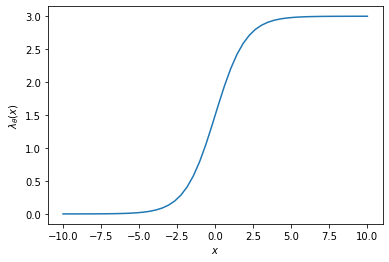

In [126]:
x_array = np.linspace(-10, 10)
plt.plot(x_array, λ(x_array, θ))
plt.xlabel(r"$x$")
plt.ylabel(r"$\lambda_\theta(x)$")
plt.show()

## Simulation

In [127]:
def evolve(tree, t, key):
    r"""Evolve an ETE Tree node with a phenotype attribute for time t"""
    λ_x = λ(tree.x, θ)
    Λ = λ_x + μ + m
    time_key, event_key = random.split(key)
    τ = random.exponential(time_key) / Λ
    if τ > t:
        child = ete3.Tree(name=tree.name + 1, dist=t)
        child.add_feature("x", tree.x)
        child.add_feature("t", tree.t + t)
        child.add_feature("event", "sampled" if random.uniform(event_key) < ρ else "unsampled")
        tree.add_child(child)
        return

    possible_events = ["birth", "death", "mutation"]
    event_probabilities = np.array([λ_x, μ, m]) / Λ
    event = possible_events[random.choice(event_key, len(possible_events), p=event_probabilities)]

    child = ete3.Tree(name=tree.name + 1, dist=τ)
    child.add_feature("t", tree.t + τ)
    child.add_feature("x", tree.x)
    child.add_feature("event", event)
    if event == "birth":
        child1_key, child2_key = random.split(event_key)
        evolve(child, t - τ, child1_key)
        evolve(child, t - τ, child2_key)
    elif event == "death":
        pass
    elif event == "mutation":
        mutation_key, child_key = random.split(event_key)
        child.x += random.normal(mutation_key)
        evolve(child, t - τ, child_key)
    else:
        raise ValueError(f"unknown event {node.event}")
    tree.add_child(child)

Simulate some trees

In [128]:
n_trees = 10
# simulation sampling time
T = 3

trees = []

seed = 0
key = random.PRNGKey(seed)

for i in range(n_trees):
    while True:
        # initialize root
        tree = ete3.Tree(name=0, dist=0)
        tree.add_feature("t", 0)
        tree.add_feature("x", 0)
        tree.add_feature("event", None)
        # get new seed
        key, _ = random.split(key)
        evolve(tree, T, key)
        if 50 < len(tree) < 96:
            print(f"tree {i + 1}, size {len(tree)}")
            break
    trees.append(tree)

tree 1, size 52
tree 2, size 66
tree 3, size 58
tree 4, size 74
tree 5, size 93
tree 6, size 56
tree 7, size 69
tree 8, size 83
tree 9, size 52
tree 10, size 91


Render the completely observed tree process with colors according to phenotype. Green nodes indicate sampled cells.

tree 1


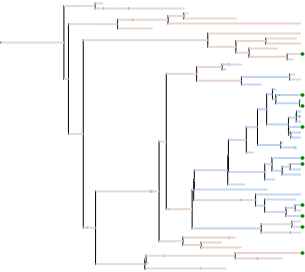

tree 2


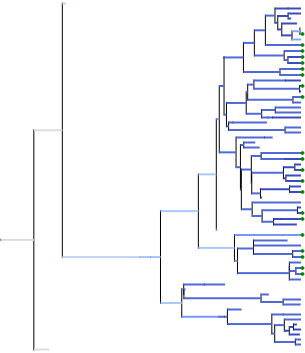

tree 3


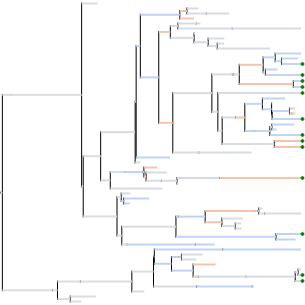

tree 4


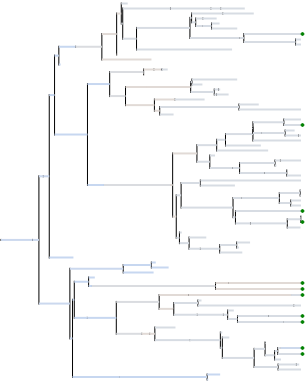

tree 5


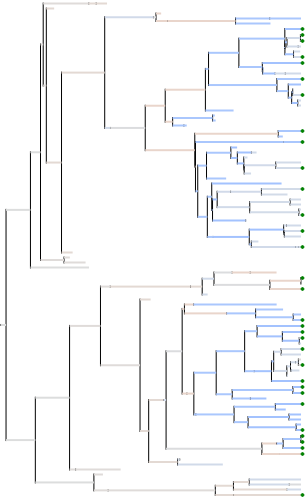

tree 6


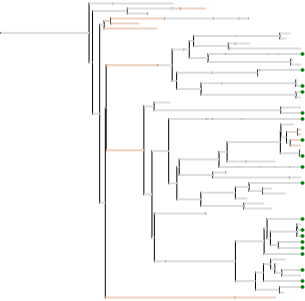

tree 7


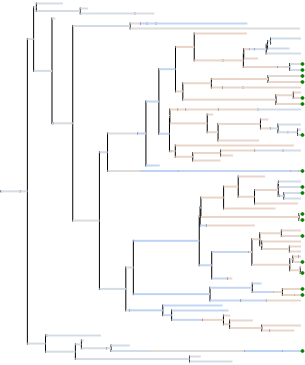

tree 8


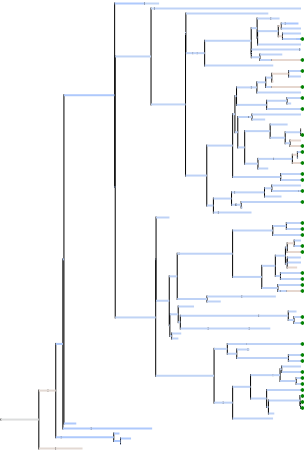

tree 9


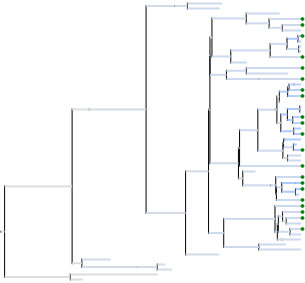

tree 10


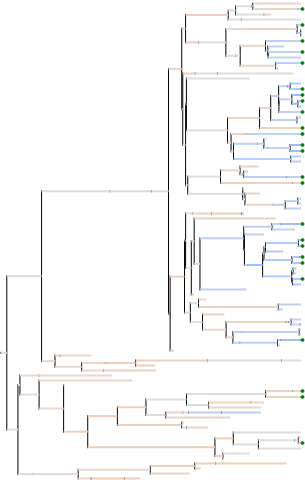

In [129]:
cmap = "coolwarm_r"
cmap = mp.cm.get_cmap(cmap)

# define the minimum and maximum values for our colormap
# normalizer = mp.colors.Normalize(vmin=-10, vmax=10)
normalizer = mp.colors.CenteredNorm(vcenter=0,
                                    halfrange=max(abs(node.x)
                                                  for tree in trees for node in tree.traverse()))

for i, tree in enumerate(trees, 1):
    print(f"tree {i}")
    colormap = {node.name: mp.colors.to_hex(cmap(normalizer(node.x)))
                for node in tree.traverse()}


    ts = ete3.TreeStyle()
    ts.scale = 100
    ts.branch_vertical_margin = 3
    ts.show_leaf_name = False
    ts.show_scale = False

    for node in tree.traverse():
        nstyle = ete3.NodeStyle()
        nstyle["hz_line_color"] = colormap[node.name]
        nstyle["hz_line_width"] = 2
        if node.is_leaf() and node.event == "sampled":
            nstyle["fgcolor"] = "green"
            nstyle["size"] = 3
        else:
            nstyle["size"] = 0
        node.set_style(nstyle)

    display(tree.render("%%inline", tree_style=ts))

**To do: prune to the tree induced by the green samples**

Histogram of phenotypes and fitnesses (root value indicated with vertical line)

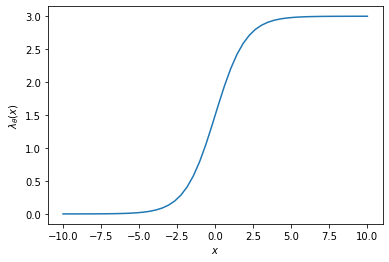

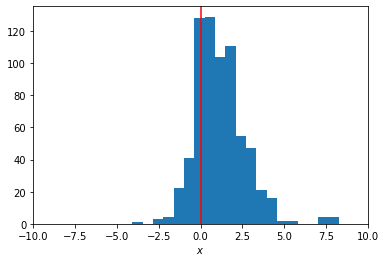

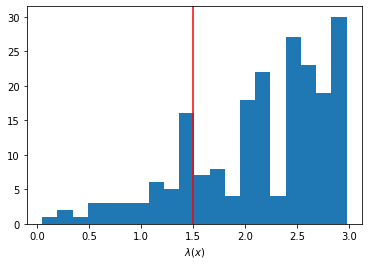

In [130]:
x_obs = [float(node.x) for tree in trees for node in tree]
λ_obs = [float(λ(node.x, θ)) for tree in trees for node in tree if node.event == "sampled"]

plt.plot(x_array, λ(x_array, θ))
plt.xlabel(r"$x$")
plt.ylabel(r"$\lambda_\theta(x)$")
plt.show()

plt.hist(x_obs, bins=20)
plt.axvline(0, c="r")
plt.xlabel("$x$")
plt.xlim(x_array.min(), x_array.max())
plt.show()

plt.hist(λ_obs, bins=20)
plt.axvline(λ(0, θ), c="r")
plt.xlabel("$\lambda(x)$")
plt.show()

## Inference

For now, assume we have the completely observed process, including extinct lineages

In [131]:
@jit
def log_likelihood(θ):
    result = 0
    for tree in trees:
        for node in tree.children[0].traverse():
            x = node.up.x
            Δt = node.dist
            λ_x = λ(x, θ)
            Λ = λ_x + μ + m
            logΛ = np.log(Λ)
            if node.event in ("sampled", "unsampled"):
                # exponential survival function (no event before sampling time), then sampling probability
                result += - Λ * Δt + np.log(ρ if node.event == "sampled" else 1 - ρ)
            else:
                # exponential density for event time
                result += logΛ - Λ * Δt
                # multinomial event probability
                if node.event == "birth":
                    result += np.log(λ_x) - logΛ
                elif node.event == "death":
                    result += np.log(μ) - logΛ
                elif node.event == "mutation":
                    Δx = node.x - x
                    result += np.log(m) - logΛ + norm.logpdf(Δx)
                else:
                    raise ValueError(f"unknown event {node.event}")
    return result

Plot the likelihood function over each parameter

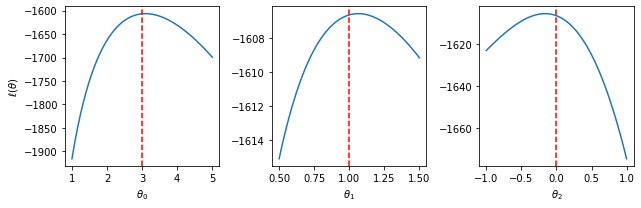

In [132]:
plt.figure(figsize=(9, 3))

plt.subplot(131)
θ0_array = np.linspace(1, 5)
plt.plot(θ0_array, [log_likelihood(np.array([θ0, θ[1], θ[2]])) for θ0 in θ0_array])
plt.axvline(θ[0], c="r", ls="--")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\ell(\theta$)")

plt.subplot(132)
θ1_array = np.linspace(0.5, 1.5)
plt.plot(θ1_array, [log_likelihood(np.array([θ[0], θ1, θ[2]])) for θ1 in θ1_array])
plt.axvline(θ[1], c="r", ls="--")
plt.xlabel(r"$\theta_1$")

plt.subplot(133)
θ2_array = np.linspace(-1, 1)
plt.plot(θ2_array, [log_likelihood(np.array([θ[0], θ[1], θ2])) for θ2 in θ2_array])
plt.axvline(θ[2], c="r", ls="--")
plt.xlabel(r"$\theta_2$")

plt.tight_layout()
plt.show()

In [133]:
@jit
def g(θ):
    return -log_likelihood(θ)

grad_g = jit(grad(g))

@jit
def h(θ):
    return 0

@jit
def prox(θ, s):
    return np.clip(θ, np.array([1e-1, -np.inf, -np.inf]))

In [134]:
optimizer = opt.AccProxGrad(g, grad_g, h, prox, verbose=True)

θ_inferred = optimizer.run(np.array([3., 1., 0.]), max_iter=1000, tol=0)
θ_inferred

initial objective 1.606651e+03
iteration 1000, objective 1.605e+03, relative change 2.309e-14                                                                                                                                                                                                                                                                                                                                                                                                       
maximum iteration 1000 reached with relative change in objective function 2.3e-14


DeviceArray([ 2.70086856,  1.32079162, -0.35600263], dtype=float64)

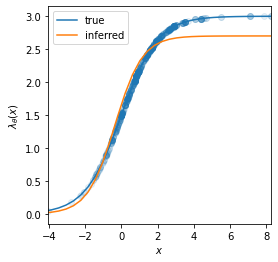

In [135]:
x_array = np.linspace(-10, 10)
plt.figure(figsize=(4, 4))
plt.plot(x_array, λ(x_array, θ), label="true")
plt.plot(x_obs, λ(np.array(x_obs), θ), "o", c="C0", alpha=0.1)
plt.plot(x_array, λ(x_array, θ_inferred), label="inferred")
plt.xlabel(r"$x$")
plt.ylabel(r"$\lambda_\theta(x)$")
plt.xlim(min(x_obs), max(x_obs))
plt.legend()
plt.show()

## New content...

We need a way to assess convergence, so let's keep track of the objective value over time.

In [136]:
def MLE(init_value, num_iters = 1000, plot_trace = True):
    optimizer = opt.AccProxGrad(g, grad_g, h, prox, verbose=False)
    optimizer._initialize(np.array(init_value))

    objective_trace = []

    for iter in range(num_iters):
        optimizer._step()
        objective_trace.append(optimizer.f())

    if plot_trace:
        x_array = np.arange(num_iters) + 1
        plt.figure(figsize=(4, 4))
        plt.plot(x_array, objective_trace)
        plt.xlabel("Iteration")
        plt.ylabel("Objective")
        plt.show()

    return optimizer.x, objective_trace

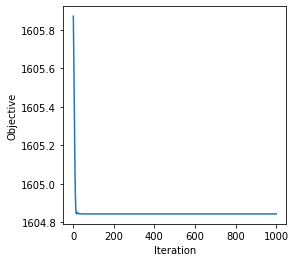

In [137]:
mle, objective_trace = MLE(init_value = [3., 1., 0.])

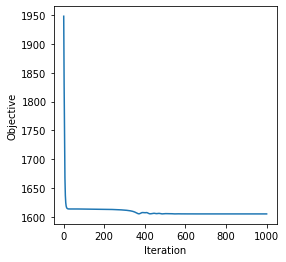

In [143]:
mle, objective_trace = MLE(init_value = [8., 8., 8.])

In [139]:
import itertools
import seaborn as sns
from tqdm import tqdm

def assess_convergence(search_range, num_iters = 1000):
    search_space = itertools.product(search_range, search_range, search_range)
    search_space = [np.array(t) for t in search_space]

    magnitudes = []
    objectives = []

    optimizer = opt.AccProxGrad(g, grad_g, h, prox, verbose=False)

    for θ_init in tqdm(search_space):
        try:
            magnitudes.append(np.sqrt(np.power(θ - θ_init, 2).sum()))
            optimizer.run(θ_init, max_iter = num_iters, tol = 0)
            objectives.append(optimizer.f())

        except RuntimeError: # invalid gradient
            objectives.append(np.nan)

    magnitudes = np.array(magnitudes)
    objectives = np.array(objectives)

    p = sns.scatterplot(x = magnitudes, y = objectives)
    p.set(xlabel = r"$||\theta - \theta\_init||$", ylabel = "Objective function at solution")

    return search_space, objectives

100%|██████████| 125/125 [00:29<00:00,  4.19it/s]


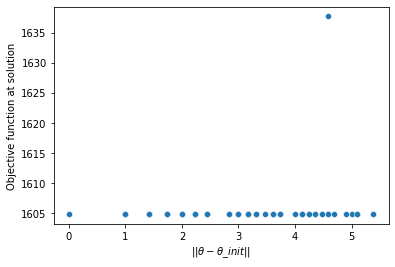

In [140]:
search_space, objectives = assess_convergence(search_range = np.arange(0., 5.))

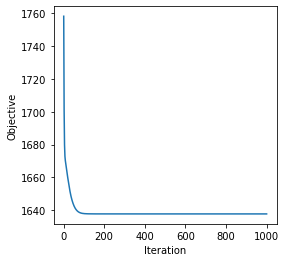

In [149]:
bad_init_value = search_space[np.nanargmax(objectives)]

mle, objective_trace = MLE(init_value = bad_init_value)